In [1]:
import os
import math
import time
import numpy as np
import pandas as pd
from functools import partial
import pyarrow
import fastparquet

# Pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split, Dataset, DataLoader

# Pytorch Lightening
import pytorch_lightning as pl

# For Visualization
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline     
sns.set(color_codes=True)

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
# local imports
from data_loading import load_data, SNPDataModule

In [4]:
input_file = "HO_data/HO_data_filtered/HumanOrigins2067_filtered.parquet"

In [5]:
snp_data = load_data(input_file)

In [6]:
snp_data.shape

torch.Size([160858, 2067])

In [7]:
# Verification
unique_values = np.unique(snp_data)
print("Unique values after normalization:", unique_values)  # Should show [0.0, 0.5, 1.0, 9.0]

Unique values after normalization: [0.  0.5 1.  9. ]


- _LightningDataModule_

In [8]:
# initialize DataModule
snp_data_module = SNPDataModule(input_path=input_file, batch_size=256, num_workers=1)

In [9]:
# Setup Data
snp_data_module.setup()

In [10]:
# Train DataLoader
train_loader = snp_data_module.train_dataloader()

In [11]:
# Get a batch from DataLoader
sample_batch = next(iter(train_loader))

In [12]:
print("Batch Shape:", sample_batch.shape)  # Expected: (batch_size, num_markers)
print("First 5 Samples:\n", sample_batch[:5])  # Show first 5 rows

Batch Shape: torch.Size([256, 2067])
First 5 Samples:
 tensor([[0.5000, 0.0000, 0.5000,  ..., 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.5000,  ..., 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000,  ..., 0.5000, 0.5000, 0.5000],
        [1.0000, 0.5000, 0.5000,  ..., 1.0000, 0.5000, 1.0000],
        [0.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 0.0000]])


In [13]:
x0 = sample_batch[0]
x0.shape

torch.Size([2067])

### 1. Sinusoidal Positional Embeddings

In [14]:
# import from model.py (import only corrected versions)
from model import SinusoidalPositionalEmbeddings, UniformDiscreteTimeSampler

#### _1.1 Linear Time Sampler with SinusoidalPositionalEmbeddings_

time shape: torch.Size([1000])
embedding shape: torch.Size([1000, 500])


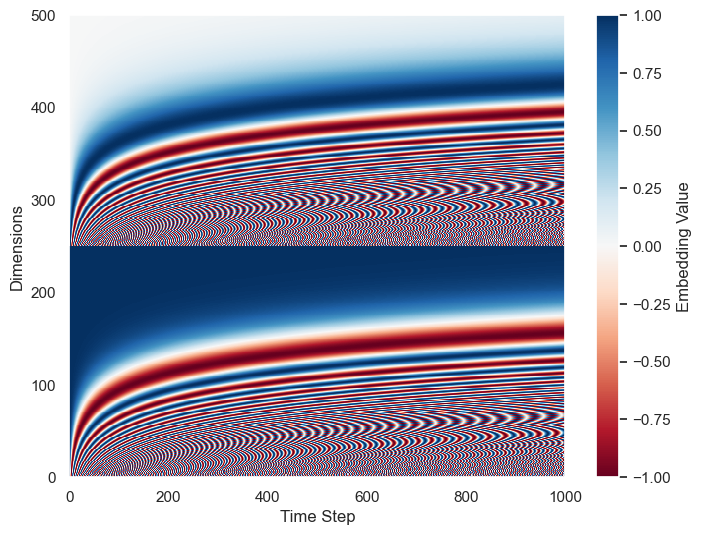

In [15]:
# Linear time sampler
timesteps = 1000  # Number of time steps
time = torch.arange(timesteps, dtype=torch.float32)  # Linear time sampler
print(f"time shape: {time.shape}")

# Sinusoidal Positional Embeddings
embedding_dim = 500  # Embedding dimensions
position_emb = SinusoidalPositionalEmbeddings(dim=embedding_dim)
emb = position_emb(time)  # Shape: [1000, 500]
print(f"embedding shape: {emb.shape}")

# Plot the embeddings
plt.figure(figsize=(8,6))
plt.pcolormesh(emb.T, cmap='RdBu', shading='auto')  # Transpose to align time on x-axis
plt.ylabel('Dimensions')
plt.xlabel('Time Step')
plt.colorbar(label="Embedding Value")
plt.show()

#### _1.2 Uniform Time Sampler with SinusoidalPositionalEmbeddings_

time shape: torch.Size([1000])
embedding shape: torch.Size([1000, 500])


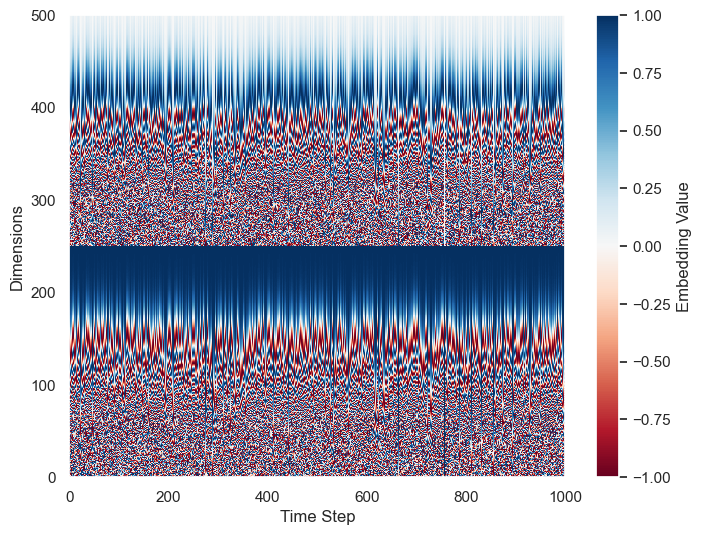

In [16]:
# Linear time sampler
timesteps = 1000  # Number of time steps
time_sampler = UniformDiscreteTimeSampler(tmin=0, tmax=timesteps)
time = time_sampler.sample(shape=(timesteps,))  # Uniform time sampler
print(f"time shape: {time.shape}")

# Sinusoidal Positional Embeddings
embedding_dim = 500  # Embedding dimensions
position_emb = SinusoidalPositionalEmbeddings(dim=embedding_dim)
emb = position_emb(time)  # Shape: [1000, 500]
print(f"embedding shape: {emb.shape}")

# Plot the embeddings
plt.figure(figsize=(8,6))
plt.pcolormesh(emb.T, cmap='RdBu', shading='auto')  # Transpose to align time on x-axis
plt.ylabel('Dimensions')
plt.xlabel('Time Step')
plt.colorbar(label="Embedding Value")
plt.show()

- By adding this Time Embedding to the hidden layer value, we can add time information to the hidden layer value.

In [17]:
# time sample: tmin=0, tmax=1000, 
time_sampler = UniformDiscreteTimeSampler(tmin=0, tmax=1000)
time = time_sampler.sample(shape=(timesteps,))  # sample time

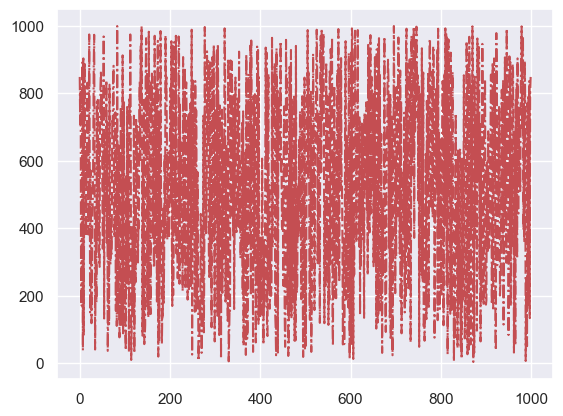

In [18]:
plt.plot(time, "r-.")

In [19]:
emb.shape

torch.Size([1000, 500])

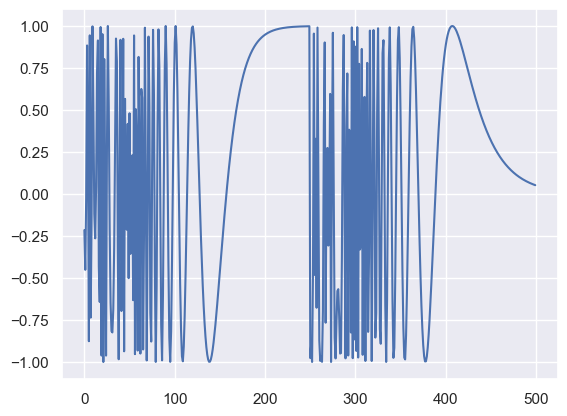

In [20]:
plt.plot(emb[0])

### _2. DDPM Process_

- _Adding Gussian Noise to the Input Data (Forward Process)_

In [21]:
from model import DDPMProcess

In [22]:
# create the model
time_steps = 1000
diffusion_process = DDPMProcess(num_diffusion_timesteps=time_steps, beta_start=0.00001, beta_end=0.02)
time_sampler = UniformDiscreteTimeSampler(tmin=diffusion_process.tmin, tmax=diffusion_process.tmax)

In [23]:
# x0 = sample_batch[0]  # i.e. input data, one example from a batch
t = time_sampler.sample(shape=(x0.shape[0],))
eps = torch.randn_like(x0, device=x0.device)  # Sample noise
xt = diffusion_process.sample(x0, t, eps)  # corrupted input data

In [24]:
x0

tensor([0.5000, 0.0000, 0.5000,  ..., 0.0000, 0.0000, 0.0000])

In [25]:
xt

tensor([[ 0.1185,  0.3850,  0.9153,  ...,  1.8220, -0.2827,  0.0420],
        [ 0.3049,  0.3278,  0.9834,  ...,  1.5513, -0.2407,  0.0357],
        [ 0.4177,  0.2416,  0.9178,  ...,  1.1435, -0.1774,  0.0263],
        ...,
        [ 0.4852,  0.1294,  0.7531,  ...,  0.6124, -0.0950,  0.0141],
        [ 0.4936,  0.1006,  0.7019,  ...,  0.4762, -0.0739,  0.0110],
        [ 0.0534,  0.3896,  0.8599,  ...,  1.8441, -0.2861,  0.0425]])

- **Visualize Diffusion (`x0` and `xt`)?**

### _Denoising Process_

- _Denoisng the Corrupted Input Data (Backward Process)_

In [30]:
# Residual Join, Downsampling, Upsampling, ConvBlock and ResnetBlock
from model import Residual, DownsampleConv, UpsampleConv, ConvBlock, ResnetBlock
from model import UNet1D

In [31]:
# Denoising Process: UNet
class UNet1D(nn.Module):
    def __init__(
        self,
        embedding_dim=64,          # Embedding dimension for time embeddings
        dim_mults=(1, 2, 4, 8),    # Multipliers for feature dimensions at each UNet level
        channels=1,                # Input channels (SNP data has a single channel)
        with_time_emb=True,        # Whether to include time embeddings
        resnet_block_groups=8,     # Number of groups in ResNet blocks for GroupNorm
    ):
        super().__init__()

        self.channels = channels
        init_dim = (2 * embedding_dim) // 3  # Ensure integer division
        init_dim = init_dim - (init_dim % resnet_block_groups)  # Ensure divisibility        
        out_dim = channels  # Default output channels to match input
        
        # Initial convolutional layer (expands input channels to init_dim)
        self.init_conv = nn.Conv1d(channels, init_dim, kernel_size=7, padding=3)

	
    	# Compute feature dimensions for each UNet level
        dims = [init_dim, *map(lambda m: embedding_dim * m, dim_mults)]
        in_out = list(zip(dims[:-1], dims[1:]))

        resnet_block = partial(ResnetBlock, groups=resnet_block_groups)

        # Time embeddings
        if with_time_emb:
            time_dim = embedding_dim
            self.time_mlp = nn.Sequential(
                SinusoidalPositionalEmbeddings(embedding_dim),
                nn.Linear(embedding_dim, time_dim),
                nn.GELU(),
                nn.Linear(time_dim, time_dim)
            )
        else:
            time_dim = None
            self.time_mlp = None

        
        # number of block iterators
        num_resolutions = len(in_out)

        # Downsampling
        self.downs = nn.ModuleList([])
        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (num_resolutions - 1)
            self.downs.append(
                nn.ModuleList([
                    resnet_block(dim_in, dim_out, time_emb_dim=time_dim),
                    resnet_block(dim_out, dim_out, time_emb_dim=time_dim),
                    nn.Identity(),  # No Attention
                    DownsampleConv(dim_out) if not is_last else nn.Identity(),
                ])
            )

        # Middle Block
        mid_dim = dims[-1]
        self.mid_block1 = resnet_block(mid_dim, mid_dim, time_emb_dim=time_dim)
        self.mid_block2 = resnet_block(mid_dim, mid_dim, time_emb_dim=time_dim)

        # Upsampling
        self.ups = nn.ModuleList([])
        for ind, (dim_in, dim_out) in enumerate(reversed(in_out[1:])):
            is_last = ind >= (num_resolutions - 1)
            self.ups.append(
                nn.ModuleList([
                    resnet_block(dim_out * 2, dim_in, time_emb_dim=time_dim),
                    resnet_block(dim_in, dim_in, time_emb_dim=time_dim),
                    nn.Identity(),  # No Attention
                    UpsampleConv(dim_in) if not is_last else nn.Identity(),
                ])
            )

        # Final Convolution
        # self.final_conv = nn.Sequential(
        #    resnet_block(embedding_dim, embedding_dim),
        #    nn.Conv1d(embedding_dim, out_dim, 1)
        #)

        # New: final convolution should match the last upsampled feature dimension instead of blindly assuming embedding_dim
        self.final_conv = nn.Sequential(
            resnet_block(dims[0], dims[0]),  # dims[0] is the first level of feature map size
            nn.Conv1d(dims[0], out_dim, 1)   # dims[0] should match the final upsampled layer output
        )

    def forward(self, x, time):
        """
        Forward pass for UNet1D.

        Args:
            x (torch.Tensor): Input SNP data of shape [batch, 1, seq_len].
            time (torch.Tensor): Diffusion timesteps of shape [batch].
        
        Returns:
            torch.Tensor: Denoised output.
        """
        # Ensure input has shape [batch, 1, seq_len]
        if x.dim() == 2:  
            x = x.unsqueeze(1)  # Convert [batch, seq_len] → [batch, 1, seq_len]

        # Rest of Forward pass
        x = self.init_conv(x)
        t = self.time_mlp(time) if self.time_mlp else None
        h = []

        # Downsampling
        for block1, block2, _, downsample in self.downs:
            x = block1(x, t)
            x = block2(x, t)
            h.append(x)
            x = downsample(x)

        # Middle
        x = self.mid_block1(x, t)
        x = self.mid_block2(x, t)

        # Upsampling
        for block1, block2, _, upsample in self.ups:
            x = torch.cat((x, h.pop()), dim=1)
            x = block1(x, t)
            x = block2(x, t)
            x = upsample(x)

        return self.final_conv(x)

- We pass `x`, `t` to model aka `forward()` pass. Where `t` comes from time sampler.

In [32]:
# now denoise xt to recover x0 at time t
model = UNet1D(
    embedding_dim=64,       # Default embedding dimension
    dim_mults=(1, 2, 4, 8), # Feature dimension multipliers
    channels=1,             # SNP data has a single channel (also out_dim)
    with_time_emb=True,     # Includes time embeddings
    resnet_block_groups=8   # Number of groups for GroupNorm in ResNet blocks
)

In [ ]:
x0_dn = model(xt, t)

## _Diffusion Model_

In [ ]:
from model import DiffusionModel, NetConfig

In [ ]:
model = DiffusionModel(diffusion_process, time_sampler, net_config=NetConfig(), data_shape=(6,))

In [ ]:
model